## Notebook Title: Attributions on Cityscapes

This notebook demonstrates how SegClarity can be used to compute, visualize, and interpret attributions for deep learning models trained on the Cityscapes semantic segmentation dataset. It leverages XAI techniques to better understand model predictions at the pixel and region level for urban scene understanding.
#
**Purpose**:  
- To apply attribution methods (e.g., Grad-CAM, DeepLift, LRP) to segmentation models trained on Cityscapes images.
- To visualize and compare attribution maps with original street scene images and ground truth masks.
- To facilitate model interpretability and support error analysis in semantic segmentation for urban environments.
#
**Key Features**:
- Loads pre-trained segmentation model (UNET) for the Cityscapes dataset.
- Supports multiple attribution methods from Captum and custom utilities.
- Generates and visualizes attribution heatmaps over Cityscapes images.
- Provides side-by-side comparison of attributions, input images, and segmentation masks.
#
**Workflow**:
1. Configure dataset and model parameters for Cityscapes.
2. Load the appropriate pre-trained segmentation model.
3. Select and apply attribution methods to validation images.
4. Visualize attribution maps alongside original images and ground truth.
5. Analyze and interpret the results for model transparency and insight into model behavior.
#
**Dataset**:  
- Cityscapes: 20-class semantic segmentation of urban street scenes.

In [1]:
import os
import sys
from pathlib import Path
# Add parent directory to path
sys.path.append("..")

import torch
import numpy as np
import matplotlib.pyplot as plt
from Modules.Architecture import generate_model
from Modules.ModelXAI import generate_XAI_model
from Modules.Utils import (
    get_layer_by_name,
    clip_fixed_percentage,
    Normalizations,
    apply_otsu,
)
import Modules.Evaluation as ev

from Modules.Attribution.constants import (
    LUNET_LAYERS_JOURNAL,
    UNET_LAYERS_JOURNAL,
)
from Modules.Attribution import generateAttributions

from Modules.Visualization import (
    generate_heatmap,
)
from Modules.Visualization.tools import split_components
from Modules.Visualization.core import visualize_image

from Modules.CityscapeDataset.core import create_cityscapes_dataloaders
from Modules.CityscapeDataset.tools import decode_segmap

from skimage.transform import resize

absolute_path = Path('..')

dataset_type='cityscapes'

_, val_loader, _  = create_cityscapes_dataloaders(
    root=absolute_path / "datasets" / "cityscapes",
    batch_size=1,
    num_workers=2,
    augment_train=None,
)


base_dir: str = f"../datasets/{dataset_type}"
device = 'cuda:0'
model_type = 'unet'

OUT_CHANNELS = 20
models_path = f"../models/{dataset_type}/{model_type}"
model_name = f"best_model.pth"


print(f"Loading model from {models_path}")
print(f"Model name: {model_name}")


# %%
print("Loading model...")
model = generate_model(
    model_type= model_type, 
    out_channels=OUT_CHANNELS, 
    load_from_checkpoint=True,
    models_path=models_path, 
    checkpoint_name=model_name
).eval().to(device)

# Prepare model for XAI
model = generate_XAI_model(model=model, device=device)

/media/bonobo/flaref/SegClarity/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Loading model from ../models/cityscapes/unet
Model name: best_model.pth
Loading model...
../models/cityscapes/unet/best_model.pth
Model loaded successfully


In [2]:
for image_batch,mask_batch,names in val_loader:
    image_batch = image_batch.to(device)
    mask_batch = mask_batch.to(device)
    break

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-4.053115898461357e-09..0.9999999964237213].
/tmp/ipykernel_3486980/1093255253.py:7: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


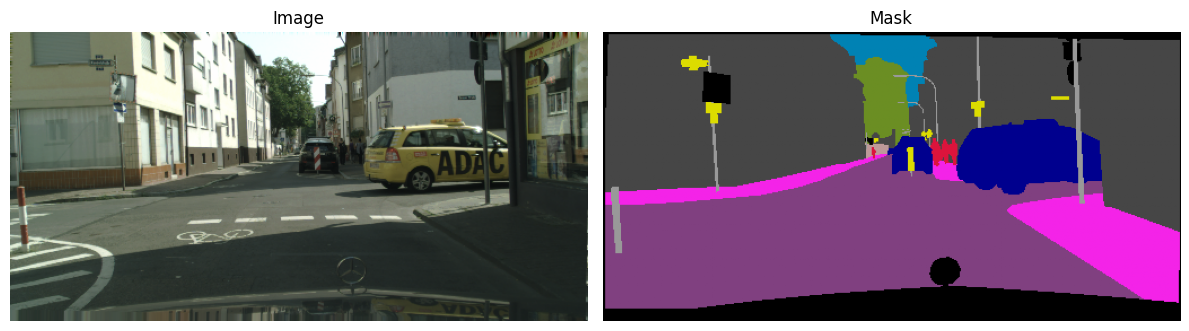

In [3]:
pred= model(image_batch).max(dim=1)[1]

fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].imshow(image_batch[0].permute(1, 2, 0).detach().cpu().numpy() * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406]));_ = ax[0].axis('off'); ax[0].set_title('Image')
ax[1].imshow(decode_segmap(mask_batch[0].detach().cpu()));_ = ax[1].axis('off'); ax[1].set_title('Mask')
fig.tight_layout()
fig.show()


### Attribution Computation

In [4]:
# choose method between LayerLRP, LayerDeepLift, LayerGradientXActivation, LayerGradCam
method = "LayerDeepLift"
selected_target = 14

layers = LUNET_LAYERS_JOURNAL if model_type == "lunet" else UNET_LAYERS_JOURNAL
layers = list(layers.keys())
layer_name = layers[-3];print(layer_name)

layer_mapper = {
    "conv1.0": "Dec4",
    "conv2.0": "Dec3",
    "conv3.0": "Dec2",
    "conv4.0": "Dec1",    
    "conv5.0": "Dec4",
    "conv6.0": "Dec3",
    "conv7.0": "Dec2",
    "conv8.0": "Dec1",
    "final_layer": "FL",
}

attr = generateAttributions(image_batch, model, selected_target, method, get_layer_by_name(model, layer_name))
attr = clip_fixed_percentage(attr,p=0.05)

if attr.max() > 10e4:
    attr = Normalizations.pick('normalize_log')(attr)

pv,nv,zv = split_components(attr,zero_threshold=0.05)


conv7.0


### Visualize heatmap

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.8260139..3.7576396].


torch.Size([3, 128, 256])


/media/bonobo/flaref/SegClarity/Notebooks/../Modules/Visualization/core.py:242: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


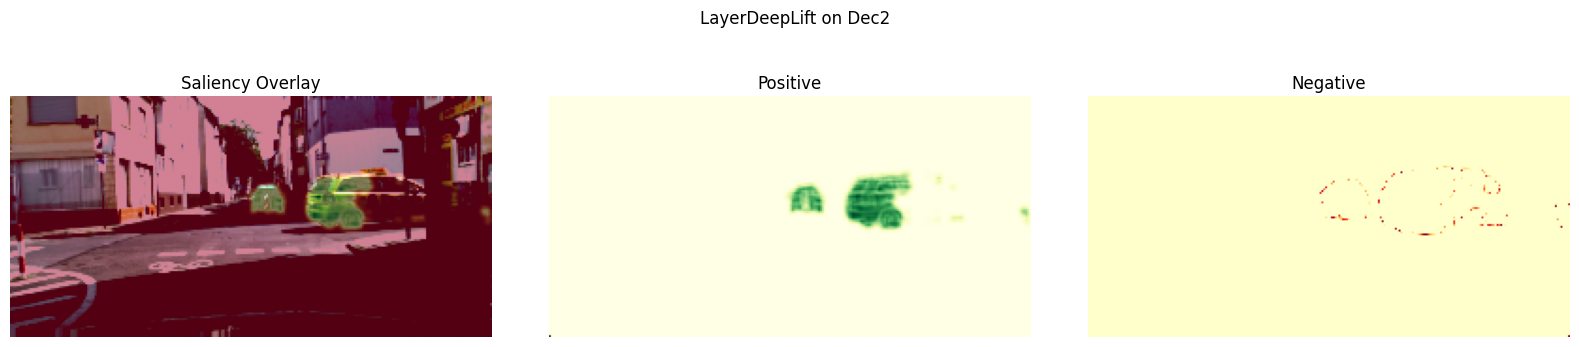

In [5]:
fig,axes = plt.subplots(1,3,figsize=(16,8))
fig.suptitle(f"{method} on {layer_mapper[layer_name]}",y=0.75)


saliency_mask = pv - nv
if nv.sum() == 0:
    cmap="YlGn"
elif pv.sum() == 0:
    cmap="YlOrRd"
    saliency_mask = -saliency_mask
else:
    cmap="RdYlGn"
viz_image = image_batch.squeeze().detach().cpu()

viz_image = torch.from_numpy(resize(viz_image, (3,*attr.shape[-2:]), anti_aliasing=True))

print(viz_image.shape)

_ = visualize_image(viz_image,fig=fig,ax=axes[0]);axes[0].set_title("Saliency Overlay")
axes[0].imshow(pv.detach().cpu().squeeze().numpy(), cmap=cmap, alpha=0.5); axes[0].axis("off")
            
_ = generate_heatmap(pv, fig=fig, ax=axes[1],title="Positive")
_ = generate_heatmap(nv, fig=fig, ax=axes[2],title="Negative")

### Evaluation

**PG Score**

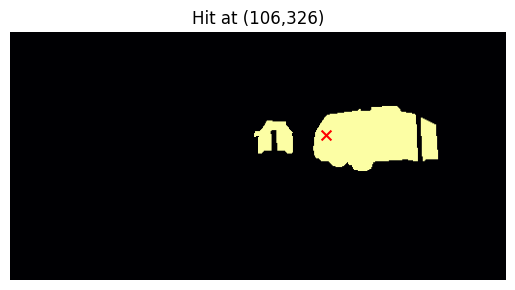

In [6]:
pg_metric = ev.PointingGameMetric()

M = torch.zeros_like(mask_batch)
M[mask_batch == selected_target] = 1
pg_score = pg_metric.calculate(saliency_map=attr,gt_mask=M.squeeze())

import torch
import matplotlib.pyplot as plt

plt.imshow(M[0].detach().cpu().numpy(),cmap='inferno');plt.axis('off')

from captum.attr import LayerAttribution
saliency_map = attr.detach().cpu().clone()
if saliency_map.shape[-2:] != mask_batch.shape[-2:]:
    saliency_map = LayerAttribution.interpolate(
                    saliency_map, mask_batch.squeeze().shape[-2:]
    )

p = torch.argmax(saliency_map).item()
h,w = saliency_map.shape[-2:]
l = p // w
c = p % w

plt.scatter(c,l,color='red',s=50,marker='x')
msg = "Hit" if M[0,l,c] == 1 else "Miss"

_= plt.title(f"{msg} at ({l},{c})")

**CH Score**

In [7]:
ch_metric = ev.ContentHeatmapMetric()

ch_score = ch_metric.calculate(attr=attr,mask=mask_batch,target=selected_target)
print(ch_score)

0.3303702473640442


<Axes: title={'center': 'Score: 0.998 [with Otsu]'}>

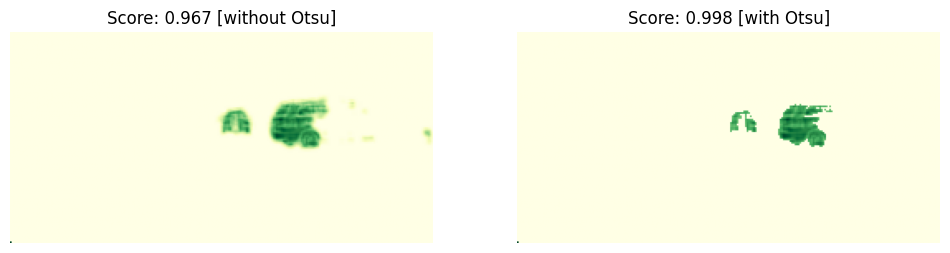

In [8]:
acs_metric = ev.ACSMetric()

metrics, _ = acs_metric.calculate(attr,mask_batch.detach().cpu(), selected_target)
acs = metrics["f1"]
attr_otsu, _ = apply_otsu(attr.detach().cpu())
metrics_otsu, _ = acs_metric.calculate(attr_otsu,mask_batch.detach().cpu(),selected_target)
acs_otsu = metrics_otsu["f1"]

fig,axes = plt.subplots(1,2,figsize=(12,6))
generate_heatmap(attr,fig=fig,ax=axes[0],title=f'Score: {acs:.3f} [without Otsu]')
generate_heatmap(attr_otsu,fig=fig,ax=axes[1],title=f'Score: {acs_otsu:.3f} [with Otsu]')

**Sensitivity max**

In [9]:
sens_metric = ev.SensitivityMaxMetric(n_perturb_samples=10,perturb_radius=0.02,max_examples_per_batch=1)
sens_score = sens_metric.calculate(image_batch,model,method,get_layer_by_name(model, layer_name),selected_target).item()
print(sens_score)

0.11783342063426971


**Infidelity**

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-4.053115898461357e-09..0.9999999964237213].
/tmp/ipykernel_3486980/1586206350.py:25: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


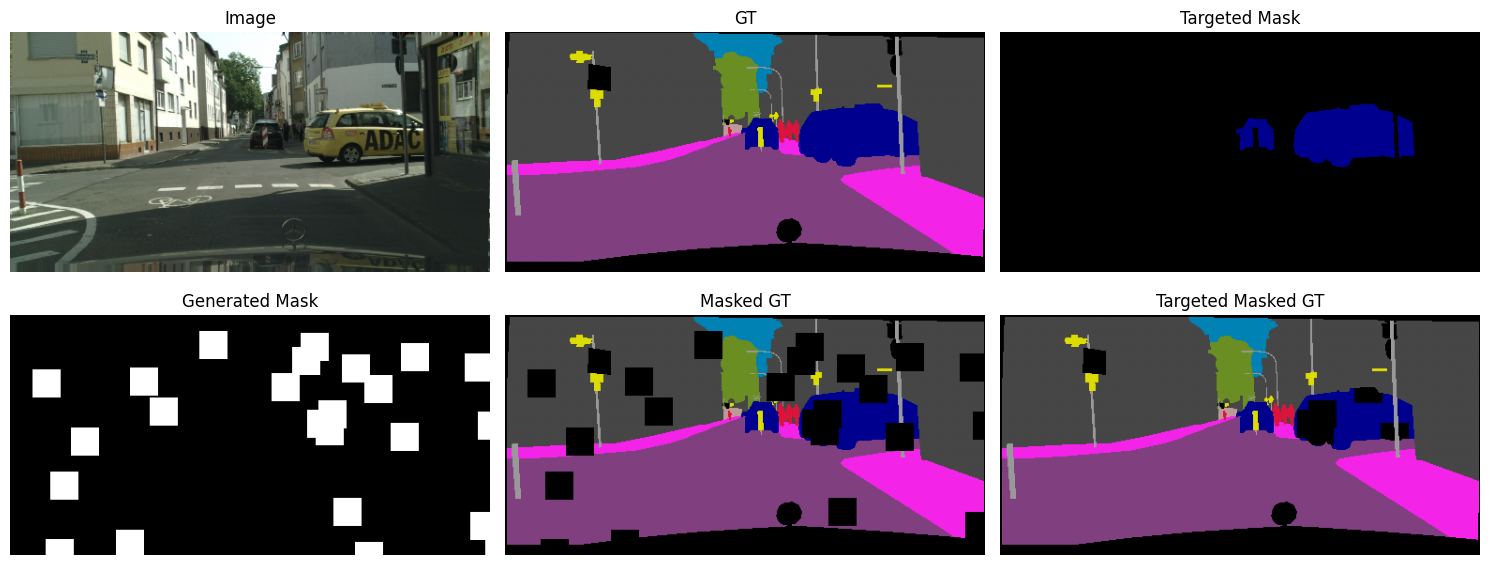

In [10]:
from Modules.Evaluation import generate_random_squares

def square_removal_perturbation(image,mask):
    image = image.clone()
    mask = mask.clone()
    image[:,mask==1] = 0
    return image,mask

squares = generate_random_squares(*mask_batch.shape[-2:],25,30)

M = torch.zeros_like(mask_batch)
for square in squares:
    M[:,square.y:square.y+square.size,square.x:square.x+square.size] = 1

targeted_mask = torch.where(mask_batch == selected_target, torch.ones_like(mask_batch), torch.zeros_like(mask_batch))

fig,axes = plt.subplots(2,3,figsize=(15,6))
axes[0,0].imshow((image_batch)[0].permute(1, 2, 0).detach().cpu().numpy() * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406]));axes[0,0].axis('off'); axes[0,0].set_title('Image')
axes[0,1].imshow(decode_segmap(mask_batch.squeeze().detach().cpu()));axes[0,1].axis('off');axes[0,1].set_title('GT')
axes[0,2].imshow(decode_segmap((targeted_mask * selected_target).squeeze().detach().cpu()));axes[0,2].axis('off');axes[0,2].set_title('Targeted Mask')
axes[1,0].imshow(M[0].detach().cpu().numpy(),cmap='gray');axes[1,0].axis('off');axes[1,0].set_title('Generated Mask')
axes[1,1].imshow(decode_segmap((mask_batch*(1-M)).squeeze().detach().cpu()));axes[1,1].axis('off');axes[1,1].set_title('Masked GT')
axes[1,2].imshow(decode_segmap((mask_batch * (1 - (targeted_mask) * M) ).squeeze().detach().cpu()));axes[1,2].axis('off');axes[1,2].set_title('Targeted Masked GT')
fig.tight_layout()
fig.show()


In [11]:
n_samples = 50

infidelity_metric = ev.InfidelityMetric()
infidelity_score = infidelity_metric.calculate(model, image_batch, mask_batch, selected_target, attr, n_samples, n_squares=50, size=10)
print(infidelity_score)

100%|██████████| 50/50 [00:01<00:00, 27.36it/s]

tensor(0.6753, device='cuda:0')
